## Here will be analysis for the first Time Since Infection Paper

#### I will include both the mouse and the monkey analyses here.

### Mouse Analysis

#### Install required packages as needed
- Not all of these installed, but it should be fine for my purposes, I hope
- If note, this github has procedures for making sure R CRAN packages get installed into conda: https://github.com/conda/conda/issues/4355
https://stackoverflow.com/questions/34705917/conda-how-to-install-r-packages-that-are-not-available-in-r-essentials

In [ ]:
# This is the correct way, that I learned in initially doing Monkey analysis in jupyter notebooks
# If I need to update packages, I may need to unlock these packages, as I can't reinstall caret with this code
#conda.r = "/master/rault/miniconda3/lib/R/library"
#install.packages("caret", conda.r)

#install.packages("deepnet", conda.r)
#devtools::install_github('topepo/caret/pkg/caret')
#install.packages("ranger", conda.r)
#install.packages("glmnet", conda.r)
#install.packages("gbm", conda.r)
#install.packages("e1071", conda.r)
#install.packages("mlbench", conda.r)

In [2]:
#source("https://bioconductor.org/biocLite.R")
#biocLite()
#biocLite("Biobase")
# biocLite("GEOquery")
# biocLite("limma")
# biocLite("multtest")
# biocLite("HybridMTest")
# biocLite("MLInterfaces")
# install.packages("scatterplot3d")
# install.packages("rgl")
# install.packages("pheatmap")
# install.packages("dplyr")
# install.packages("gplots")
# install.packages("class")
# install.packages("e1071")
# install.packages("heatmap3")
# install.packages("heatmap.plus")
# install.packages("randomForest")
# install.packages("caret")

#### Load Required Libraries

Loading all the below works, except rgl and MLInterfaces, which I should not need

In [ ]:
#library("randomForest")
#library(gplots)
#require("heatmap.plus")
#require("heatmap3")
#library(Biobase)
#library(GEOquery)
#library(limma)
#library(scatterplot3d)
#library(rgl)
#library(multtest)
#library(pheatmap)
#library(HybridMTest)
#library(class)
#library(MLInterfaces)
#library(e1071)
#library(caret)
#library(repr)
#require(dplyr) # I don't think this is needed absolutely currently

In [2]:
if (!require("preprocessCore")) {
  source("https://bioconductor.org/biocLite.R")
  biocLite("preprocessCore")
  library("preprocessCore")
}
if (!require("GGally")) {
    install.packages("GGally")
    library("GGally")
}
library(ggplot2)
library(randomForest)
library(Biobase)
library(GEOquery)

Loading required package: preprocessCore


In [4]:
# Make R graphs smaller
options(repr.plot.width=4, repr.plot.height=3)

#### Set up the environment and load in the data, applying p value of detection to whole dataset with all strains

In [5]:
source("utils.R")
path  = "/master/rault/TB"
data_path = paste(path, "/data/Mouse", sep="")

In [6]:
array_data = read.delim(paste(data_path, "P13_2011DS114_9MouseChips_BM_V4_0_R1_21Jan2011_Norm.txt", sep="/"))
QC_data = read.delim(paste(data_path,"P13_2011DS114_9MouseChips_BM_V4_0_R1_21Jan2011_QC.txt", sep="/"), header=T, skip = 8)
RNA_QC = read.delim(paste(data_path,"P13_TB_Mice_RNA QC.txt", sep="/"), header=T)
mousechip_conv = read.delim(paste(data_path,"Mousechip.txt", sep="/"), header=T)
pheno_data = read.delim(paste(data_path,"BV microarray for Baylor Annotation_Clinical.txt", sep="/"), header=T)

In [9]:
colnames(pheno_data)[1] = "Sample.Group"
pheno_data$chip.name = paste("M#", pheno_data$Donor.ID, "OSU", sep="")

In [10]:
eset = make.expression.set(array_data, pheno_data, mousechip_conv)
eset

ExpressionSet (storageMode: lockedEnvironment)
assayData: 17275 features, 50 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: M#11OSU M#12OSU ... M#72OSU (50 total)
  varLabels: Strain Infect.Status Time.point.days
  varMetadata: M#11OSU M#12OSU ... labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation:  

#### Select only C57BL/6 mice and quantile normalize their arrays

Warning message in boxplot(log2(exprs(eset.B6) + 1), ylim = c(4, 10)):
“NaNs produced”

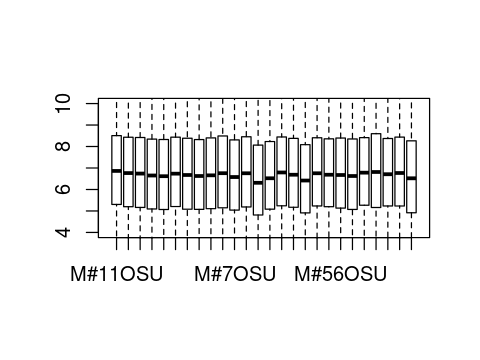

In [12]:
eset.B6 = eset[, eset$Strain=="C57BL/6"]
boxplot(log2(exprs(eset.B6) + 1), ylim=c(4,10))

Warning message in boxplot(log2(exprs(qn) + 1), ylim = c(4, 10)):
“NaNs produced”

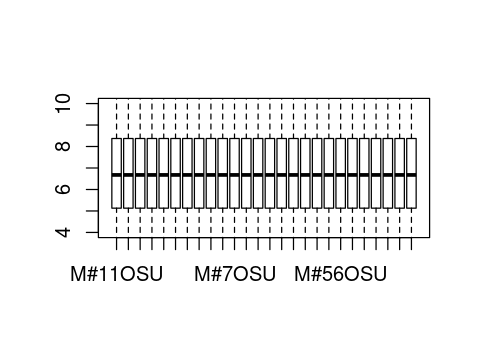

In [13]:
qn = eset.B6
exprs(qn) = normalize.quantiles(exprs(eset.B6))
boxplot(log2(exprs(qn)+1), ylim = c(4, 10))

In [64]:
# To do percentile normalization, may want to multiply by a ratio to get back to original scale for later functions, or just do everything on log scale

#per75 = apply(exprs(eset.B6.med), 2, quantile, 0.50)
#exprs(eset.B6.med) <- sweep(exprs(eset.B6.med), 2, per75, "/" )
#boxplot(exprs(eset.B6.med), ylim = c(0, 2))

#### Now find genes that are 2-fold changed from median in 10% of samples (basic filtering) and log2 transform the data

In [14]:
eset.B6.2xUDALO = normalization(qn)
exprs(eset.B6.2xUDALO) = log2(exprs(eset.B6.2xUDALO) + 1)
#boxplot(exprs(eset.B6.2xUDALO), ylim = c(4,10))   # Now not perfectly distributed because we filtered the variable genes

[1] "1717 genes passed the 2 fold change from median in 10% of samples filter"


#### We now have the detected genes from all mice and variable genes within the C57BL/6 mice 
#### Now do PCA and graph the results by M.tb infection status and time point.

In [20]:
PCA.B6 = prcomp(t(exprs(eset.B6.2xUDALO)), scale.=T)

In [21]:
gg.PCA.B6.inf = as.data.frame(PCA.B6$x[,1:5])
gg.PCA.B6.days = gg.PCA.B6.inf
gg.PCA.B6.inf$Infect.Status = eset.B6.2xUDALO$Infect.Status
gg.PCA.B6.days$Time.point.days = as.character(eset.B6.2xUDALO$Time.point.days)



#data.frame(PCA.B6$x[,1:2], Infect.Status=eset.B6.2xUDALO$Infect.Status)

##### In the dataset of all C57BL/6 mice, the first principle component clearly separates infected from uninfected mice. No other principle component separates these groups

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


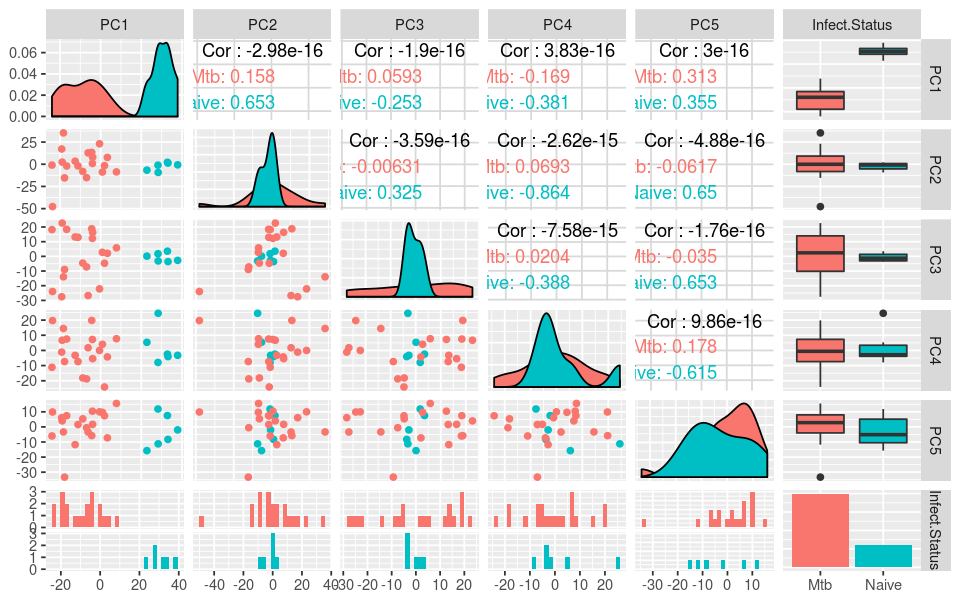

In [22]:
options(repr.plot.width=8, repr.plot.height=5)
print(ggpairs(gg.PCA.B6.inf, aes(colour = Infect.Status)))

##### This graph tells me that a combination of PCA1 and PCA3 separates the time periods in C57BL/6 mice. MaybeI should do a PCA only in infected mice too to show this point. Groups of 3 of all time points cluster alone on this plot, suggesting leave 1-out cross-validation could give better prediction, but I will keep 3-fold to not overfit.
- Also I think base R will make a better, cleaner figure for publication. But this package works very well for visualization.
- I think I could have 2 separate figures in Figure 1, one to show that all the infect and uninfect are different. One to show the time points within the infected group.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


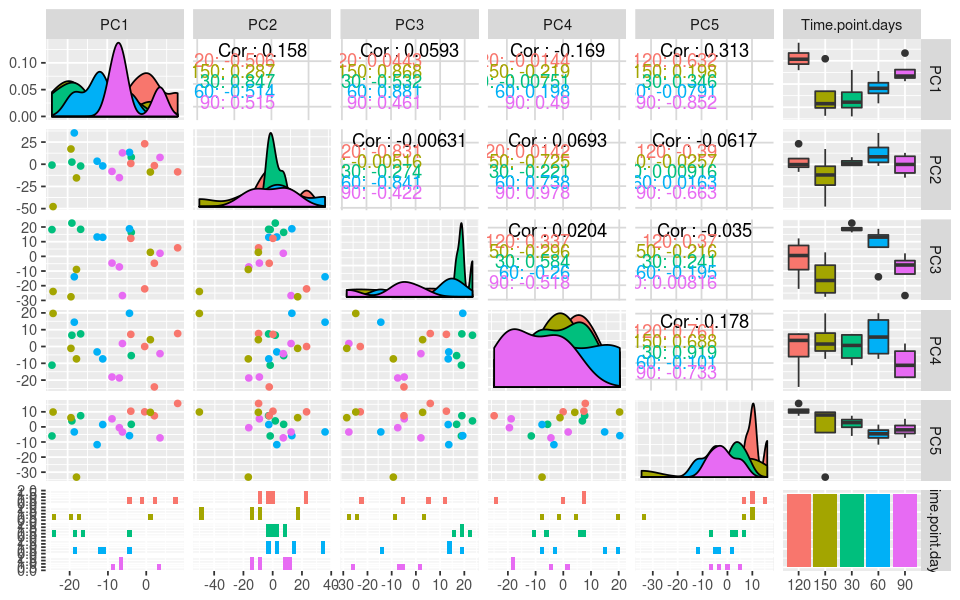

In [23]:
options(repr.plot.width=8, repr.plot.height=5)
gg.PCA.B6.Mtb = gg.PCA.B6.days[eset.B6.2xUDALO$Infect.Status == "Mtb",]
print(ggpairs(gg.PCA.B6.Mtb, aes(colour = Time.point.days)))

##### Here is PCA only in Infected mice, to visualize the time point separations without the effect of infection. Here a combination of principle component 1 & 2 separate these time points, with principle component 1 doing most of the separation. Therefore, time point explains most of the variation of the data within M.tb infected mice

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


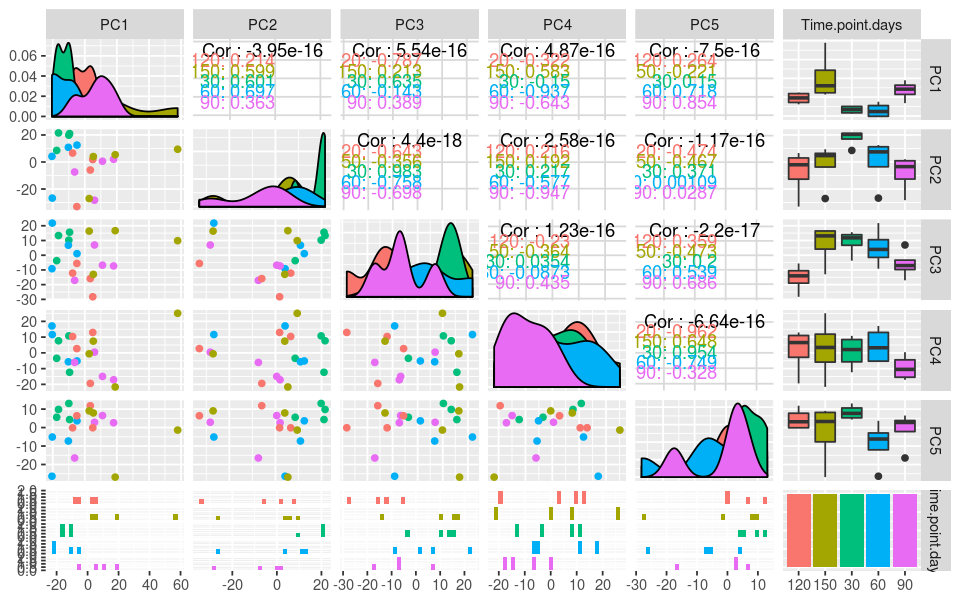

In [24]:
eset.B6.Mtb = eset.B6.2xUDALO[,eset.B6.2xUDALO$Infect.Status == "Mtb"]
PCA.B6.Mtb = prcomp(t(exprs(eset.B6.Mtb)), scale.=T)
gg.PCA.B6.Mtb = as.data.frame(PCA.B6.Mtb$x[,1:5])
gg.PCA.B6.Mtb$Time.point.days = as.character(eset.B6.Mtb$Time.point.days)
print(ggpairs(gg.PCA.B6.Mtb, aes(colour = Time.point.days)))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


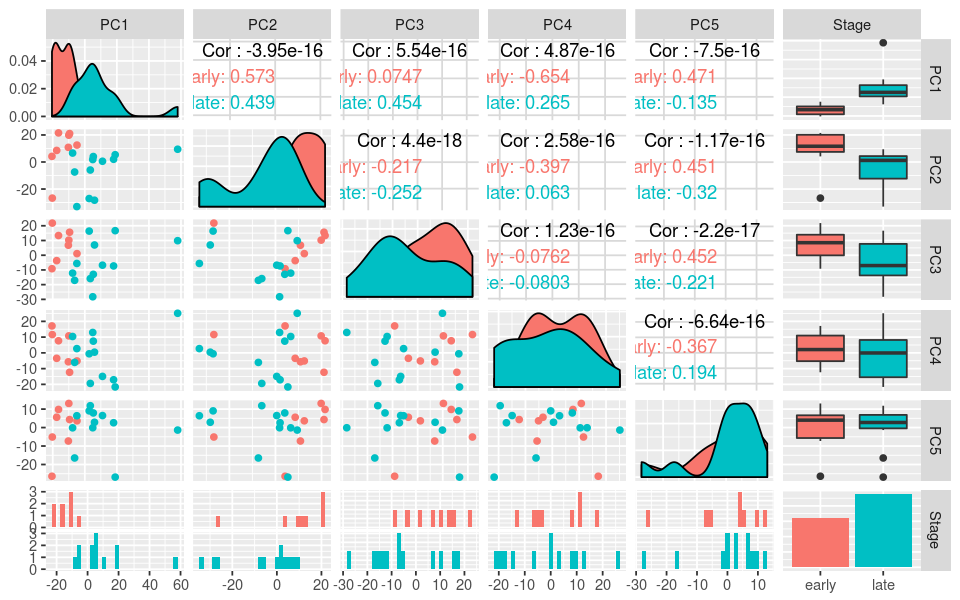

In [25]:
stage = ifelse(eset.B6.Mtb$Time.point.days <= 60,
               "early",
               "late")
gg.PCA.B6.Mtb = as.data.frame(PCA.B6.Mtb$x[,1:5])
gg.PCA.B6.Mtb$Stage = stage
print(ggpairs(gg.PCA.B6.Mtb, aes(colour = Stage)))

#### Exploratory PCA showed that the 2 major sources of variation in the data are 1) Whether mice were infected and 2) Were mice infected for 1-2 mo. vs. 3-5 mo. Now I will make the PCA graphs for Figure 1 of the paper, focusing on these two points

#### I will worry about putting the two plots into a nice figure later, after the machine learning

In [ ]:
eset.B6.Mtb = eset.B6.2xUDALO[,eset.B6.2xUDALO$Infect.Status == "Mtb"]
PCA.B6.Mtb = prcomp(t(exprs(eset.B6.Mtb)), scale.=T)
gg.PCA.B6.Mtb = as.data.frame(PCA.B6.Mtb$x[,1:5])
gg.PCA.B6.Mtb$Time.point.days = as.character(eset.B6.Mtb$Time.point.days)
print(ggpairs(gg.PCA.B6.Mtb, aes(colour = Time.point.days)))
stage = ifelse(eset.B6.Mtb$Time.point.days <= 60,
               "early",
               "late")
gg.PCA.B6.Mtb = as.data.frame(PCA.B6.Mtb$x[,1:5])
gg.PCA.B6.Mtb$Stage = stage
print(ggpairs(gg.PCA.B6.Mtb, aes(colour = Stage)))

In [91]:
#summary(PCA.B6.Mtb)
#PCA.B6.Mtb

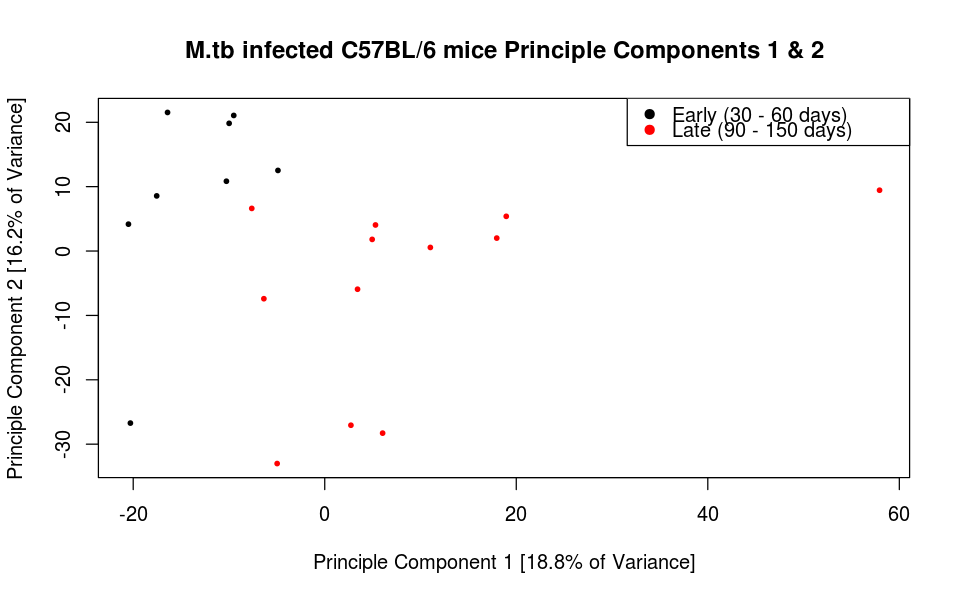

In [50]:
# Still need to put in the variance explained and also separate the legend a little. Ggplot might honestly give a better equivalent 
eset.B6.Mtb = eset.B6.2xUDALO[,eset.B6.2xUDALO$Infect.Status == "Mtb"]
PCA.B6.Mtb = prcomp(t(exprs(eset.B6.Mtb)), scale.=T)

std_dev = PCA.B6.Mtb$sdev
pr_var = std_dev^2
prop_varex = pr_var / sum(pr_var)

stage = ifelse(eset.B6.Mtb$Time.point.days <= 60,
               "early",
               "late")

plot(PCA.B6.Mtb$x[,"PC1"], PCA.B6.Mtb$x[,"PC2"], pch=19,
    cex=0.5, col=as.factor(stage),
     xlab=paste("Principle Component 1 [", format(prop_varex[1]*100, digits=3, nsmall=1), "% of Variance]", sep=""),
     ylab=paste("Principle Component 2 [", format(prop_varex[2]*100, digits=3, nsmall=1), "% of Variance]", sep=""),
     main="M.tb infected C57BL/6 mice Principle Components 1 & 2")
legend("topright", legend=c('Early (30 - 60 days)', 'Late (90 - 150 days)'), col=c("black", "red"), pch=19)

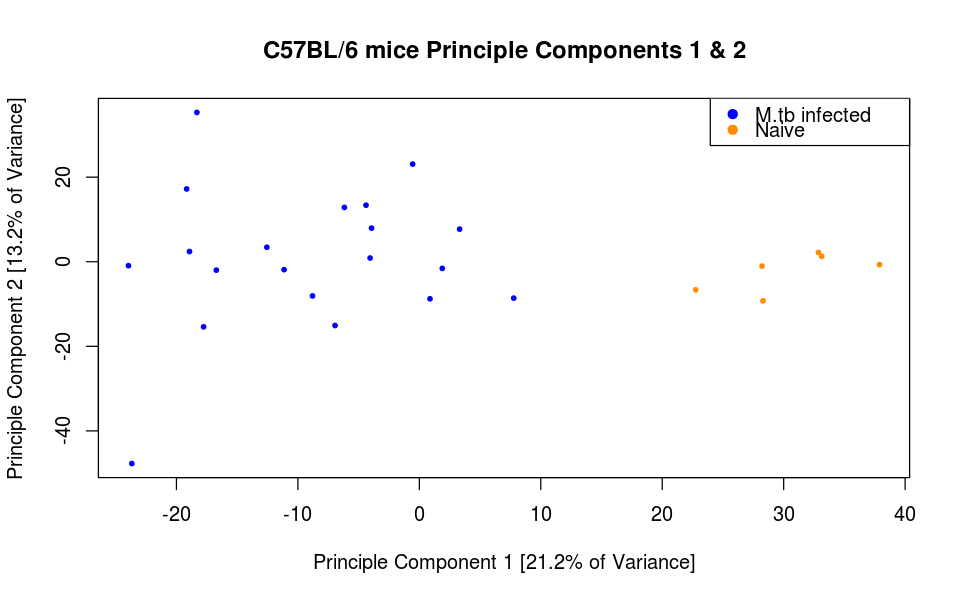

In [52]:

std_dev = PCA.B6$sdev
pr_var = std_dev^2
prop_varex = pr_var / sum(pr_var)

plot(gg.PCA.B6.inf$PC1, gg.PCA.B6.inf$PC2, pch=19,
     cex=0.5, col=ifelse(gg.PCA.B6.inf$Infect.Status=="Mtb", "blue", "darkorange"),
     xlab=paste("Principle Component 1 [", format(prop_varex[1]*100, digits=3, nsmall=1), "% of Variance]", sep=""),
     ylab=paste("Principle Component 2 [", format(prop_varex[2]*100, digits=3, nsmall=1), "% of Variance]", sep=""),
     main="C57BL/6 mice Principle Components 1 & 2")
legend("topright", legend=c('M.tb infected', 'Naive'), col=c("blue", "darkorange"), pch=19)

##### The code below is from one of my BMI 8050 homeworks, demonstrating plotting of PCA data

In [ ]:
plot(PCA.B6.Mtb$x[,"PC1"], PCA.B6.Mtb$x[,"PC2"], pch=19,
    cex=0.5, col=PCA.B6.Mtb$,
     xlab="Principle Component 1",
     ylab="Principle Component 2",
     main="M.tb infected C57BL/6 mice Principle Components 1 & 2")

In [ ]:
# 3 (b) Plot the cancer samples according to the first two principle components and visually cluster the data

df = data.frame(x=tcga_PCA$x[,"PC1"], y=tcga_PCA$x[,"PC2"])
commonTheme = list(labs(color="Density",fill="Density",
                        x="Principle Component 1",
                        y="Principle Component 2"),
                   theme_bw(),
                   theme(legend.position=c(0,1),
                         legend.justification=c(0,1)))

ggplot(data=df,aes(x,y)) + 
  geom_density2d(aes(colour=..level..)) + 
  scale_colour_gradient(low="green",high="red") + 
  geom_point() + commonTheme + ggtitle("Density Contour Map of Breast Cancer Samples by Principle Components 1 & 2")

In [ ]:
plot(tcga_PCA$x[,"PC1"], tcga_PCA$x[,"PC2"], pch=19, 
     cex=0.5, col=ifelse(tcga_PCA$x[,"PC1"] < my_cutoff, "blue", "red"),
     xlab="Principle Component 1",
     ylab="Principle Component 2",
     main="Breast Cancer Samples along Principle Components 1 & 2") 
legend("topright", legend=c('My cluster 1', 'My cluster 2'), col=c("blue", "red"), pch=19)

#### Now do Random Forests Classification and Regression on the C57BL/6 infected Mouse data

##### Classification

In [81]:
set.seed(100)
stage = ifelse(eset.B6.Mtb$Time.point.days <= 60,
               "early",
               "late")

B6.table.class = as.data.frame(t(exprs(eset.B6.Mtb)))
B6.table.class$stage = as.factor(stage)
B6.rf.class = randomForest(stage~., data=B6.table.class)

I should potentially do more work to make the table prettier and to make sure whether predictions are on the x or y axis of the table, but this result perfectly replicates what I have seen before, so I'm perfectly fine with it.

I'll have to dig more into the details when I analyze feature importance, etc.

In [82]:
B6.rf.class


Call:
 randomForest(formula = stage ~ ., data = B6.table.class) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 41

        OOB estimate of  error rate: 10%
Confusion matrix:
      early late class.error
early     7    1  0.12500000
late      1   11  0.08333333

##### Regression - the result is more dramatic with the filtering I did solely within B6 mice. Maybe filtering within only infected mice could improve results even further?
- I may need to do a transformation of the predictions to get them into a better scale
- What about doing the 5-way classification too? Could that help confirm what I am seeing?

In [83]:
# Great website for tutorial in random forests for tuning 
# http://machinelearningmastery.com/tune-machine-learning-algorithms-in-r/
B6.table.regress = as.data.frame(t(exprs(eset.B6.Mtb)))
B6.table.regress$Time.point.days = eset.B6.Mtb$Time.point.days
#C57.table = make.data.frame(exprs(C57.el.eset), C57.el.eset$Time.point.days, 
#                            "Time.point.days")
B6.table.class5 = B6.table.regress
B6.table.class5$Time.point.days = as.factor(B6.table.regress$Time.point.days)
#summary(exprs(C57.el.eset)[3,])
#summary(C57.table[,4])

#summary(C57.table[,])

In [84]:
set.seed(100)
B6.rf.class5 = randomForest(Time.point.days~., data=B6.table.class5)
B6.rf.class5


Call:
 randomForest(formula = Time.point.days ~ ., data = B6.table.class5) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 41

        OOB estimate of  error rate: 75%
Confusion matrix:
    30 60 90 120 150 class.error
30   3  1  0   0   0        0.25
60   3  1  0   0   0        0.75
90   0  0  0   2   2        1.00
120  0  0  3   1   0        0.75
150  0  0  3   1   0        1.00

In [85]:
set.seed(100)
C57.rf.regres = randomForest(Time.point.days~., data=B6.table.regress)

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”

In [86]:
str(C57.rf.regres)

List of 18
 $ call           : language randomForest(formula = Time.point.days ~ ., data = B6.table.regress)
 $ type           : chr "regression"
 $ predicted      : Named num [1:20] 58.2 69.3 58.3 63.3 69 ...
  ..- attr(*, "names")= chr [1:20] "M#23OSU" "M#24OSU" "M#25OSU" "M#26OSU" ...
 $ mse            : num [1:500] 1350 1491 1360 1003 851 ...
 $ rsq            : num [1:500] 0.25 0.172 0.245 0.443 0.527 ...
 $ oob.times      : int [1:20] 193 178 182 172 189 187 167 166 182 181 ...
 $ importance     : num [1:1717, 1] 43.74 9.62 47.61 0 0 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:1717] "ILMN_2543688" "ILMN_2435996" "ILMN_2480021" "ILMN_2734484" ...
  .. ..$ : chr "IncNodePurity"
 $ importanceSD   : NULL
 $ localImportance: NULL
 $ proximity      : NULL
 $ ntree          : num 500
 $ mtry           : num 572
 $ forest         :List of 11
  ..$ ndbigtree    : int [1:500] 9 9 7 9 7 9 9 7 9 7 ...
  ..$ nodestatus   : int [1:11, 1:500] -3 -3 -3 -1 -3 -1 -1 -1 -1 0 ...
  ..$

M#23OSU   M#24OSU   M#25OSU   M#26OSU    M#7OSU   M#32OSU   M#35OSU   M#36OSU 
 58.23057  69.25562  58.27473  63.30523  68.97619  73.54813  81.82335  75.65361 
   M#8OSU   M#43OSU   M#47OSU   M#48OSU   M#55OSU   M#56OSU   M#57OSU   M#58OSU 
113.24451 115.25967  96.65556 112.77714 109.00588 112.12500  82.42896 101.38564 
  M#10OSU   M#66OSU   M#67OSU   M#69OSU 
109.14368  98.16149 107.34359  86.98098

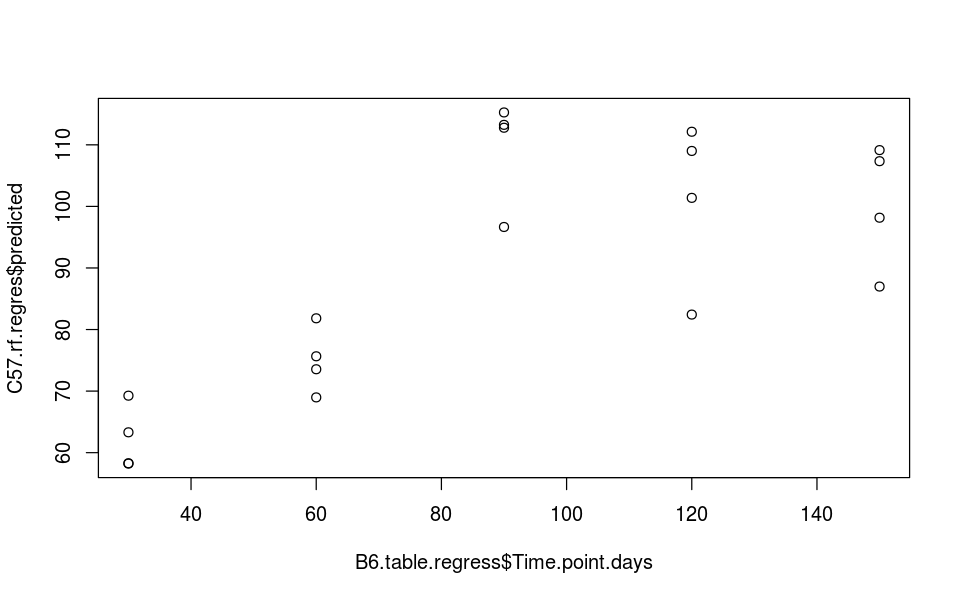

In [87]:
C57.rf.regres$predicted
plot(B6.table.regress$Time.point.days, C57.rf.regres$predicted)

In [88]:
predictions = data.frame(C57.predicted=C57.rf.regres$predicted, C57.Time.point.days = B6.table.regress$Time.point.days)
q = qplot(C57.Time.point.days, C57.predicted, data= predictions, geom = c("point", "smooth"), method="loess")

Warning message:
“Ignoring unknown parameters: method”

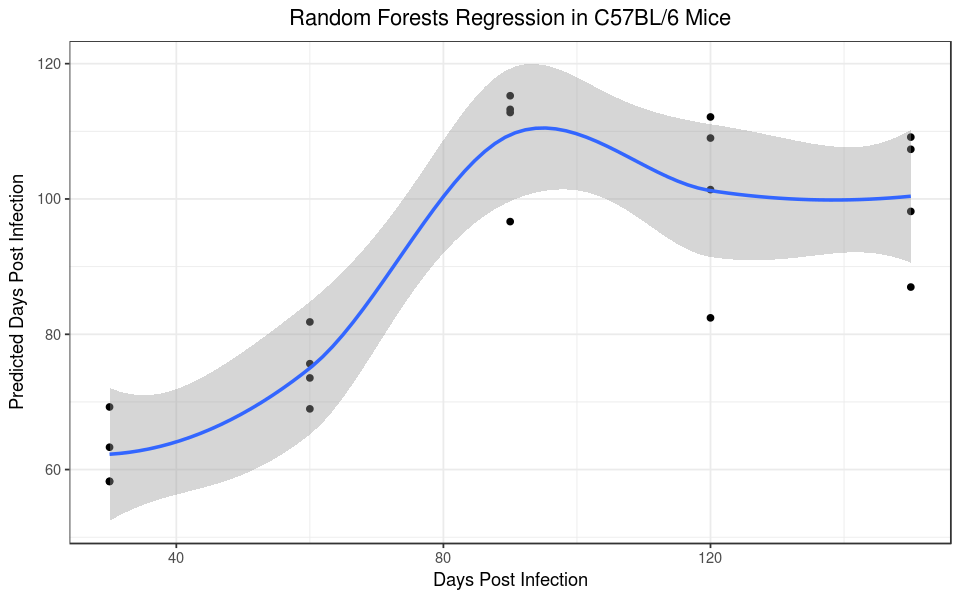

In [89]:
q + theme_bw() + 
  labs(x="Days Post Infection", y="Predicted Days Post Infection") + 
  ggtitle("Random Forests Regression in C57BL/6 Mice") +
  theme(plot.title = element_text(hjust = 0.5))

In [90]:
reg.graph.f = "Random Forests Regression of Time pi in C57BL-6 mice_29Aug2017.pdf"
pdf(reg.graph.f, width=7, height=5)
q + theme_bw() + 
  labs(x="Days Post Infection", y="Predicted Days Post Infection") + 
  ggtitle("Random Forests Regression in C57BL/6 Mice") +
  theme(plot.title = element_text(hjust = 0.5))
dev.off()

png 
  2

### Monkey Analysis

#### Load additional required libraries

In [1]:
source("https://bioconductor.org/biocLite.R")
if (!require(Biobase)) {
  biocLite("Biobase")
  library(Biobase)
}
if (!require(GEOquery)) {
  biocLite("GEOquery")
  library(GEOquery)
}

if (!require(sva)) {
  biocLite("sva")
  library(sva)
}

if (!require(randomForest)) {
  install.packages("randomForest")
  library(randomForest)
}

if (!require(ggplot2)) {
  install.packages("ggplot2")
  library(ggplot2)
}

if (!require("glmnet")) {
  install.packages("glmnet")
  library("glmnet")
}

if (!require("GGally")) {
  install.packages("GGally")
  library("GGally")
}
if (!require("caret")) {
  install.packages("caret")
  library("caret")
}
if (!require("dplyr")) {
  install.packages("dplyr")
  library("dplyr")
}
if (!require("xgboost")) {
  install.packages("xgboost")
  library("xgboost")
}
if (!require("deepnet")) {
  install.packages("deepnet")
  library("deepnet")
}
library(keras)
library(doParallel)

Bioconductor version 3.6 (BiocInstaller 1.28.0), ?biocLite for help
A new version of Bioconductor is available after installing the most recent
  version of R; see http://bioconductor.org/install
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,

#### Load data with batch correction and variable gene selection already performed

In [4]:
source("utils.R")
path  = "/master/rault/TB"
monkey_path = paste(path, "/data/Gideon_et_al_Monkey_Data", sep="")

In [5]:
# b_corr_monkey = read.table(file=paste(monkey_path, "ExpressionData_batchedall.txt", sep="/"), header=T, sep="\t")
monkey_var_genes = read.table(file=paste(monkey_path, "ExpressionData_batchcorrected_variablegenes.txt", sep="/"), header=T, sep="\t")
pheno = read.table(file = paste(monkey_path, "PhenoData_filtered.txt", sep="/"), header=T, sep="\t")

In [6]:
pheno$time.period = as.factor(ifelse(pheno$time.point < 3,
                               "pre.infect",
                               ifelse(pheno$time.point <= 10,
                                      "early", 
                                      ifelse(pheno$time.point >= 90,
                                             "late",
                                             "middle"))))

#### Perform PCA and explore separation of time periods and points graphically

In [15]:
PCA.monkey = prcomp(t(monkey_var_genes), scale.=T)

In [16]:
gg.PCA.monkey.period = as.data.frame(PCA.monkey$x[,1:5])
gg.PCA.monkey.period$time.period = pheno$time.period
gg.PCA.monkey.period$time.period = as.character(gg.PCA.monkey.period$time.period)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


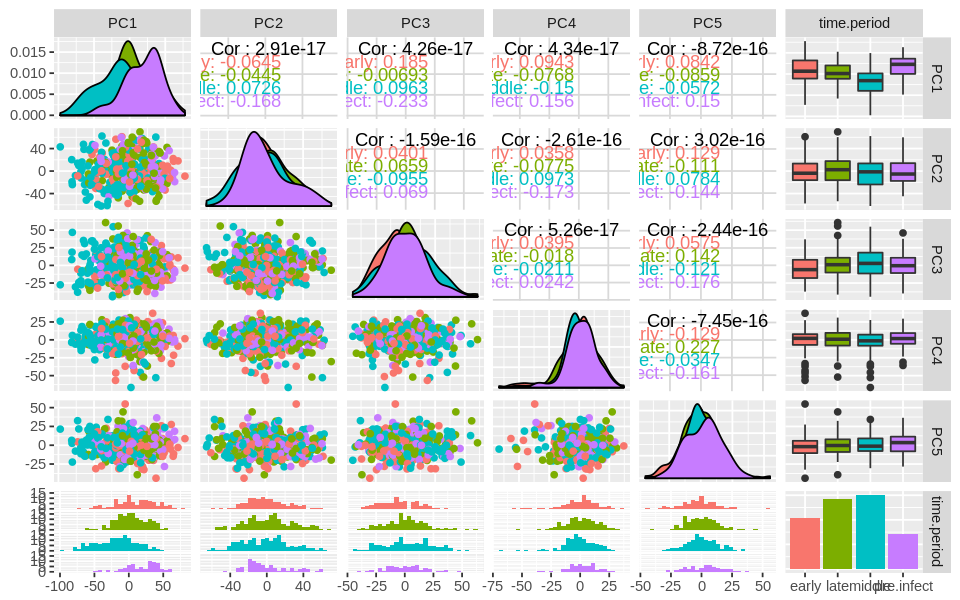

In [18]:
options(repr.plot.width=8, repr.plot.height=5)
print(ggpairs(gg.PCA.monkey.period, aes(colour = time.period)))


#data.frame(PCA.B6$x[,1:2], Infect.Status=eset.B6.2xUDALO$Infect.Status)

##### Now we will do PCA with only the infected groups, and then only the middle and late time point

In [19]:
m_infected = monkey_var_genes[, pheno$time.period != "pre.infect"]
m_middle_late = monkey_var_genes[, pheno$time.period %in% c("middle", "late")]
PCA.monkey_infect = prcomp(t(m_infected ), scale.=T)
PCA.monkey_middle_late = prcomp(t(m_middle_late ), scale.=T)

##### PCA of all time periods post-infection

In [20]:
gg.PCA.monkey.infect = as.data.frame(PCA.monkey_infect$x[,1:5])
gg.PCA.monkey.infect$time.period = pheno[pheno$time.period != "pre.infect",]$time.period
gg.PCA.monkey.infect$time.period = as.character(gg.PCA.monkey.infect$time.period)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


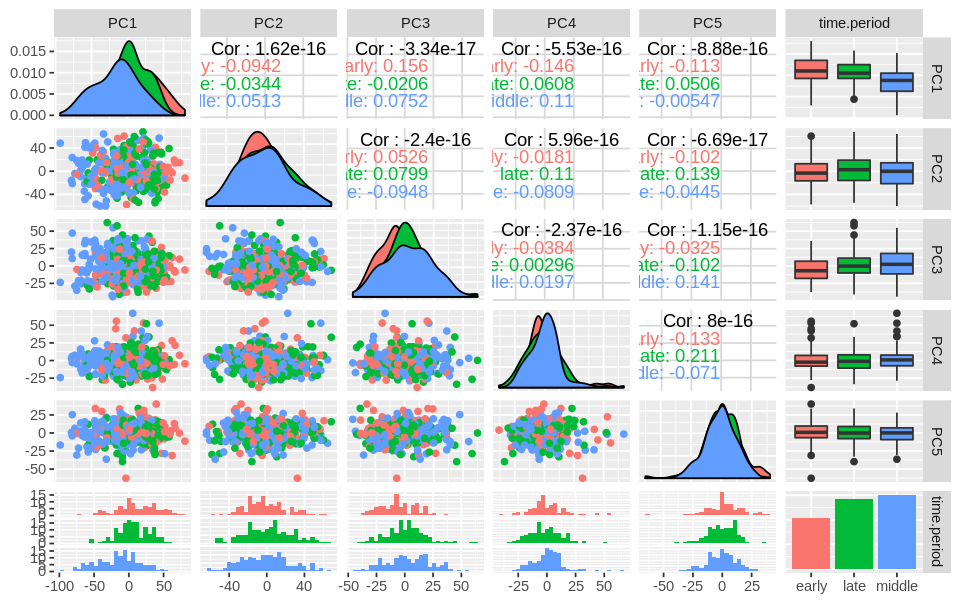

In [21]:
print(ggpairs(gg.PCA.monkey.infect, aes(colour = time.period)))

##### PCA of middle and late time periods post-infection

In [22]:
gg.PCA.monkey.m_l = as.data.frame(PCA.monkey_middle_late$x[,1:5])
gg.PCA.monkey.m_l$time.period = pheno[pheno$time.period  %in% c("middle", "late"),]$time.period
gg.PCA.monkey.m_l$time.period = as.character(gg.PCA.monkey.m_l$time.period)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


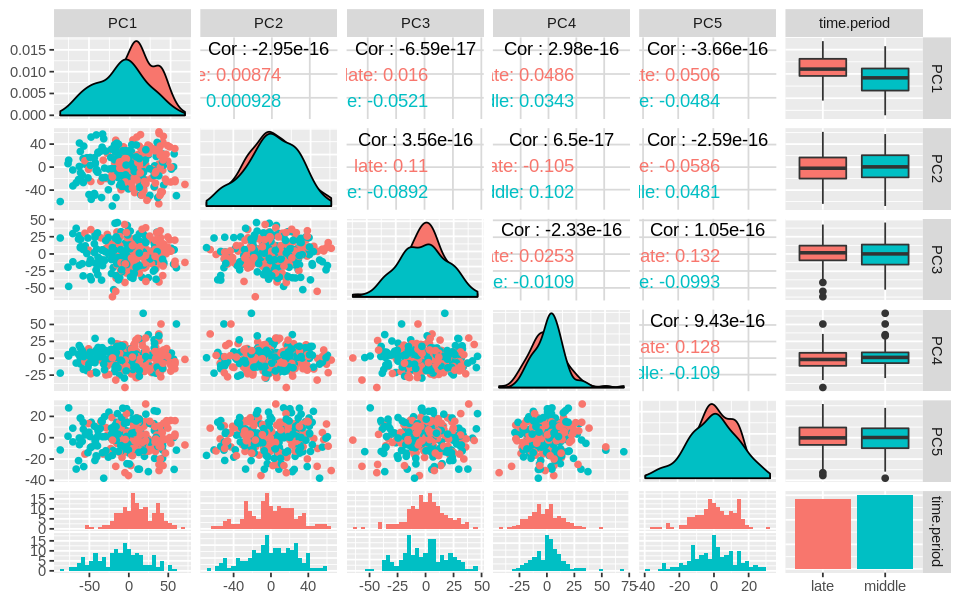

In [23]:
print(ggpairs(gg.PCA.monkey.m_l, aes(colour = time.period)))

##### PCA of all time points within middle and late periods post infection

Result: One can see that days 20, 30 and 42 are the most distinct on PC-1 from all middle and late time periods, and time point 30 is also distinct from the entire dataset (just middle and late set) along PC-3.

In [25]:
gg.PCA.monkey.m_l.point = as.data.frame(PCA.monkey_middle_late$x[,1:5])
gg.PCA.monkey.m_l.point$time.point = pheno[pheno$time.period  %in% c("middle", "late"),]$time.point
gg.PCA.monkey.m_l.point$time.point = as.character(gg.PCA.monkey.m_l.point$time.point)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


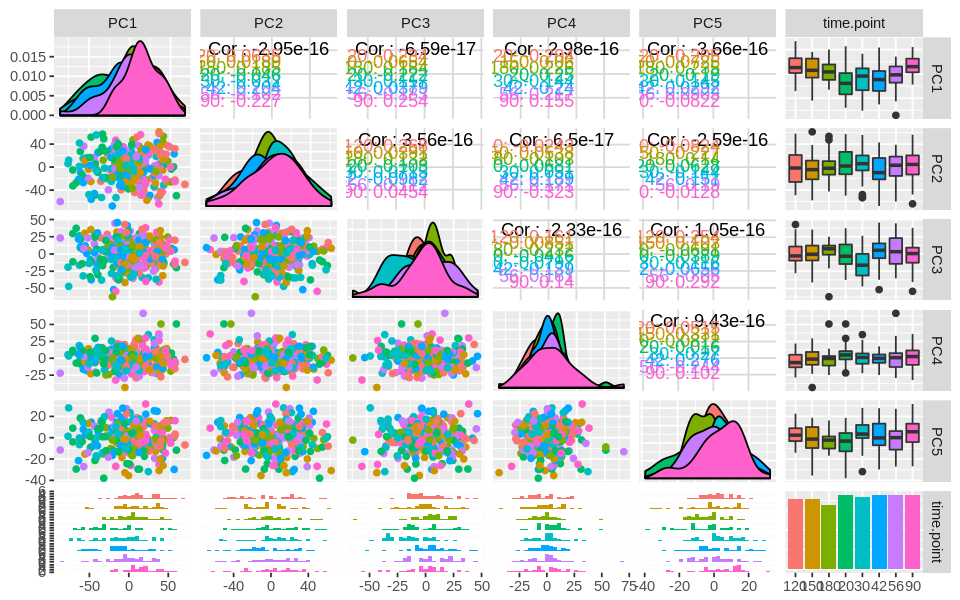

In [26]:
print(ggpairs(gg.PCA.monkey.m_l.point, aes(colour = time.point)))

#### Perform PCA and explore separation of active vs. latent disease across time periods post infection

##### PCA of all time periods with active vs latent

Result: Basically no difference between active vs. latent monkeys along PC-1-5 when looking at the entire dataset.

In [31]:
gg.PCA.monkey.disease = as.data.frame(PCA.monkey$x[,1:5])
gg.PCA.monkey.disease$clinical.status = pheno$clinical.status

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


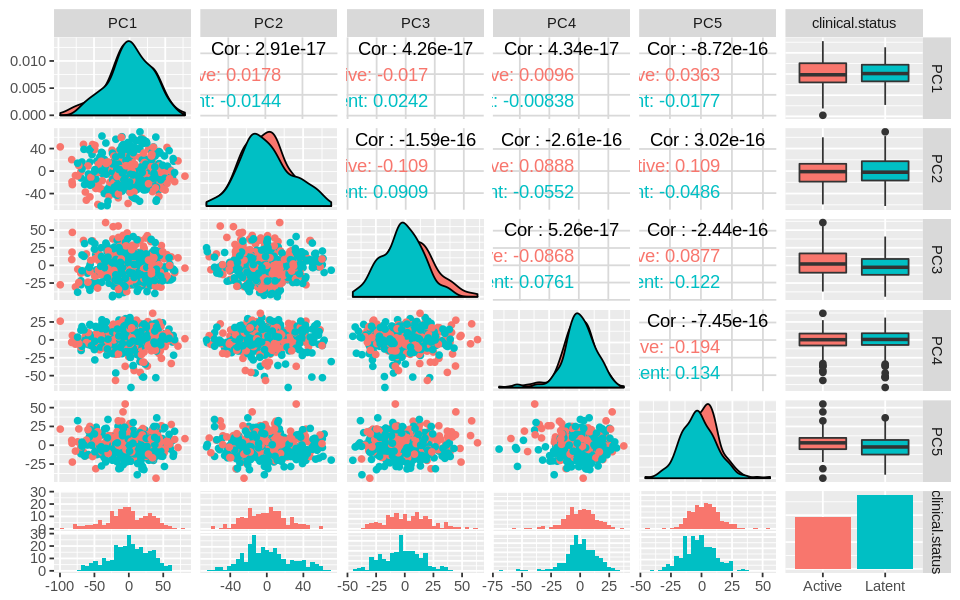

In [32]:
print(ggpairs(gg.PCA.monkey.disease, aes(colour = clinical.status)))

##### PCA of all post-infection time periods active vs latent

Result: Still basically no difference between active and latent disease

In [34]:
gg.PCA.monkey.infect.disease = as.data.frame(PCA.monkey_infect$x[,1:5])
gg.PCA.monkey.infect.disease$clinical.status = pheno[pheno$time.period != "pre.infect",]$clinical.status

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


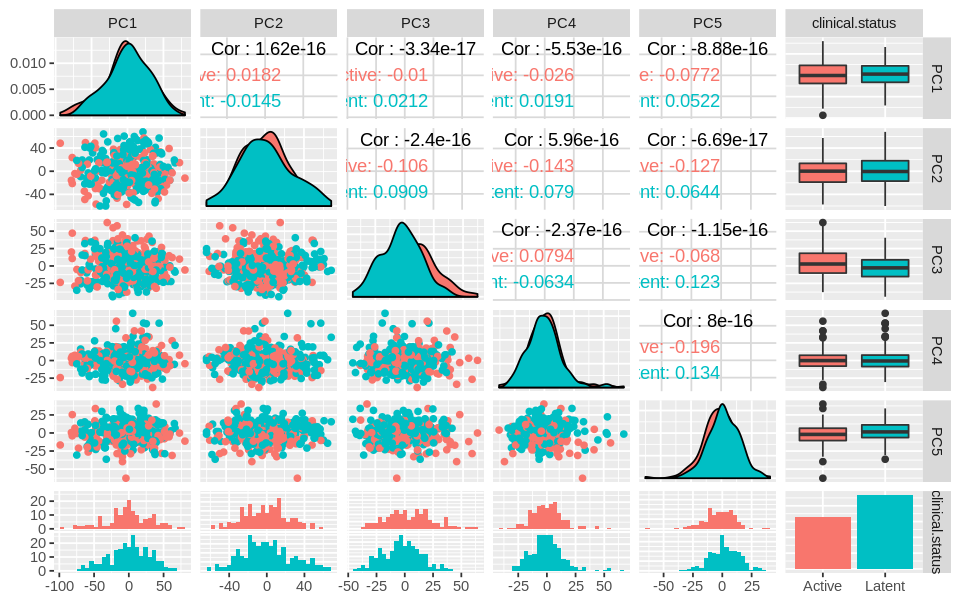

In [36]:
print(ggpairs(gg.PCA.monkey.infect.disease, aes(colour = clinical.status)))

##### PCA of all post-infection time periods individually comparing active vs latent

Result: Maybe some on PC-2,3 in late infection and a little with PC-3,5 in middle infection but overall no real separation between active and latent disease within a given time period post-infection via PCA analysis

In [37]:
m_early = monkey_var_genes[, pheno$time.period %in% c("early")]
m_middle = monkey_var_genes[, pheno$time.period %in% c("middle")]
m_late = monkey_var_genes[, pheno$time.period %in% c("late")]


PCA.monkey_early = prcomp(t(m_early), scale.=T)
PCA.monkey_middle = prcomp(t(m_middle), scale.=T)
PCA.monkey_late = prcomp(t(m_late), scale.=T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


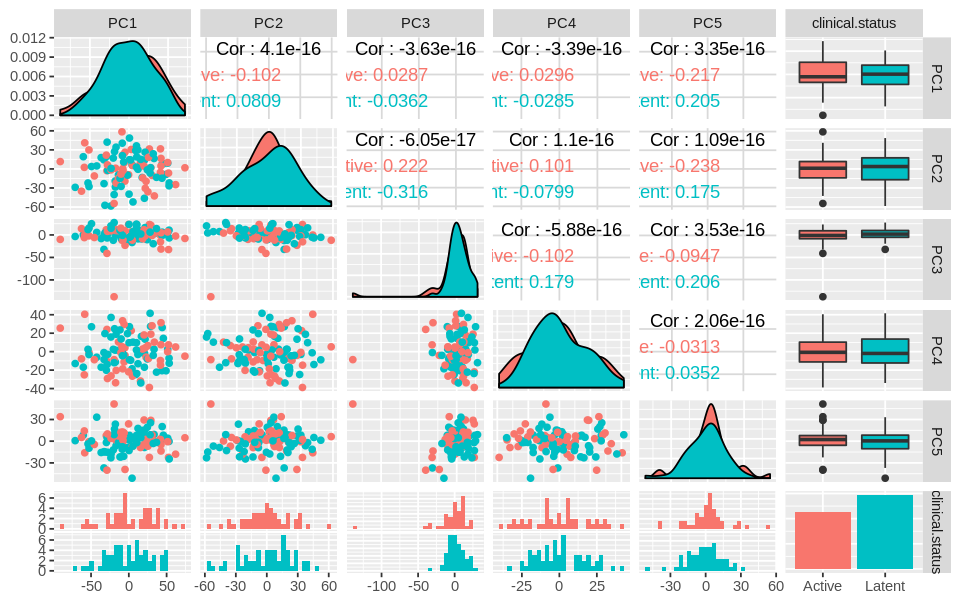

In [38]:
gg.PCA.monkey.early.disease = as.data.frame(PCA.monkey_early$x[,1:5])
gg.PCA.monkey.early.disease$clinical.status = pheno[pheno$time.period == "early",]$clinical.status
print(ggpairs(gg.PCA.monkey.early.disease, aes(colour = clinical.status)))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


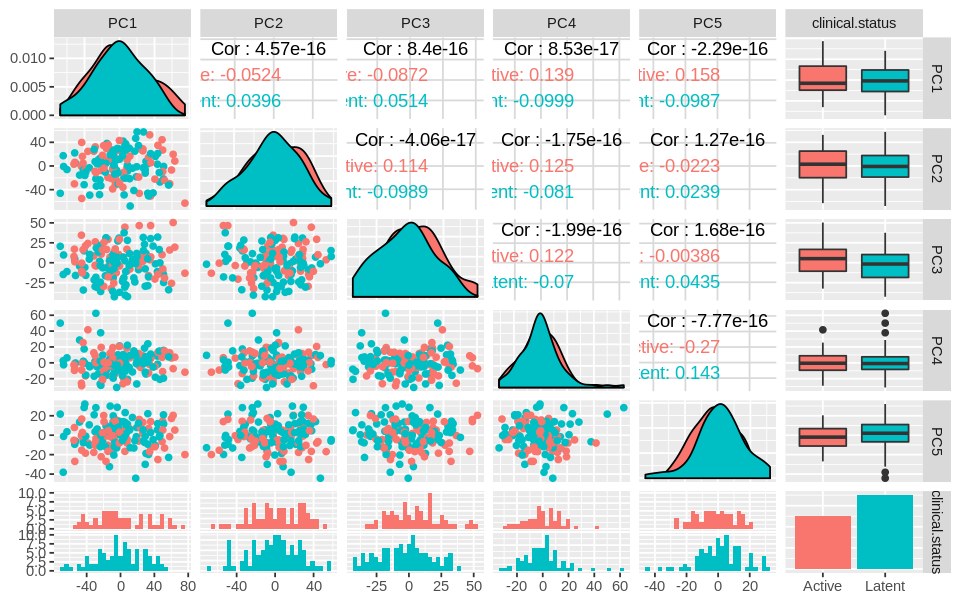

In [39]:
gg.PCA.monkey.middle.disease = as.data.frame(PCA.monkey_middle$x[,1:5])
gg.PCA.monkey.middle.disease$clinical.status = pheno[pheno$time.period == "middle",]$clinical.status
print(ggpairs(gg.PCA.monkey.middle.disease, aes(colour = clinical.status)))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


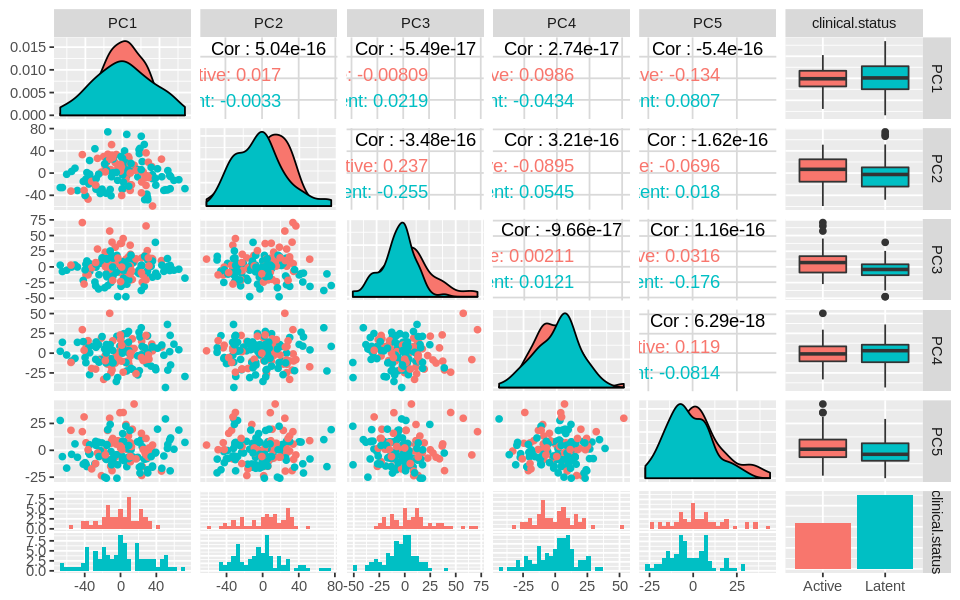

In [40]:
gg.PCA.monkey.late.disease = as.data.frame(PCA.monkey_late$x[,1:5])
gg.PCA.monkey.late.disease$clinical.status = pheno[pheno$time.period == "late",]$clinical.status
print(ggpairs(gg.PCA.monkey.late.disease, aes(colour = clinical.status)))

#### Load the classification results from my El Paso poster and confirm that the model which separates middle from late infection does not separate active and latent disease 

#### Run a caret optimization for regression using several techniques. Also include xgboost if I can. Graph the results similar to classification

##### Load middle-late data 

In [5]:
pheno_m_l = read.table(file=paste(monkey_path, "Monkey_PhenoData_middle-late.txt", sep="/"), header=T, sep="\t")
expres_m_l =  read.table(file=paste(monkey_path, "Monkey_Processed_ExpressionData_middle-late.txt", sep="/"), header=T, sep="\t")

##### Split into training and test sets, using the same random split used in python in initial neural networks training. It is 5 active TB monkeys and 6 latent TB monkeys, a roughly 70-30% train-test split.

In [6]:
test.latent.monkeys = c('M13', 'M27', 'M34', 'M15', 'M35', 'M36')
test.active.monkeys = c('M1', 'M16', 'M32', 'M18', 'M23')

In [7]:
test.rows = rownames(pheno_m_l[pheno_m_l$monkeyid %in% union(test.latent.monkeys, test.active.monkeys),])
train.rows = setdiff(rownames(pheno_m_l), test.rows)

pheno.train = droplevels(pheno_m_l[train.rows,])
pheno.test = droplevels(pheno_m_l[test.rows,])
expres.train = droplevels(expres_m_l[train.rows,])
expres.test = droplevels(expres_m_l[test.rows,])

##### Create grouped k-folds according to monkey within the training set. With seed 100, this gives 9-folds, which I am okay with

In [8]:
set.seed(100)
folds = groupKFold(pheno.train$monkeyid, k=10)
for (fold in lapply(folds, function(x) {pheno.train$monkeyid[x]}))
    print(length((as.character(fold))))

lapply(folds, function(x, y) table(y[x]), y = pheno.train$monkeyid)

[1] 202
[1] 194
[1] 186
[1] 174
[1] 187
[1] 179
[1] 186
[1] 178
[1] 194


$Fold1

M10 M11 M12 M14 M17 M19  M2 M20 M21 M22 M24 M25 M26 M28 M29  M3 M30 M31 M33 M37 
  5   8   8   0   8   7   8   8   8   8   8   8   8   8   8   8   8   7   8   8 
M38  M4  M5  M6  M7  M8  M9 
  7   8   8   8   8   8   8 

$Fold2

M10 M11 M12 M14 M17 M19  M2 M20 M21 M22 M24 M25 M26 M28 M29  M3 M30 M31 M33 M37 
  5   8   8   8   8   7   8   8   8   0   8   8   8   8   8   8   8   7   8   8 
M38  M4  M5  M6  M7  M8  M9 
  7   8   8   8   8   0   8 

$Fold3

M10 M11 M12 M14 M17 M19  M2 M20 M21 M22 M24 M25 M26 M28 M29  M3 M30 M31 M33 M37 
  5   0   8   8   8   7   8   8   8   8   8   8   0   8   8   8   0   7   8   8 
M38  M4  M5  M6  M7  M8  M9 
  7   8   8   8   8   8   8 

$Fold4

M10 M11 M12 M14 M17 M19  M2 M20 M21 M22 M24 M25 M26 M28 M29  M3 M30 M31 M33 M37 
  0   8   8   8   8   7   8   0   8   8   8   8   8   0   8   8   8   0   0   8 
M38  M4  M5  M6  M7  M8  M9 
  7   8   8   8   8   8   8 

$Fold5

M10 M11 M12 M14 M17 M19  M2 M20 M21 M22 M24 M25 M26 M28 M29  M3 M30 M31 M33 

In [9]:
set.seed(100)
pheno.train.90 = filter(pheno.train, time.point<=90)
folds.90 = groupKFold(pheno.train.90$monkeyid, k=10)
for (fold in lapply(folds.90, function(x) {pheno.train.90$monkeyid[x]}))
    print(length((as.character(fold))))

lapply(folds.90, function(x, y) table(y[x]), y = pheno.train.90$monkeyid)

[1] 129
[1] 124
[1] 119
[1] 110
[1] 119
[1] 114
[1] 119
[1] 114
[1] 124


$Fold1

M10 M11 M12 M14 M17 M19  M2 M20 M21 M22 M24 M25 M26 M28 M29  M3 M30 M31 M33 M37 
  5   5   5   0   5   5   5   5   5   5   5   5   5   5   5   5   5   4   5   5 
M38  M4  M5  M6  M7  M8  M9 
  5   5   5   5   5   5   5 

$Fold2

M10 M11 M12 M14 M17 M19  M2 M20 M21 M22 M24 M25 M26 M28 M29  M3 M30 M31 M33 M37 
  5   5   5   5   5   5   5   5   5   0   5   5   5   5   5   5   5   4   5   5 
M38  M4  M5  M6  M7  M8  M9 
  5   5   5   5   5   0   5 

$Fold3

M10 M11 M12 M14 M17 M19  M2 M20 M21 M22 M24 M25 M26 M28 M29  M3 M30 M31 M33 M37 
  5   0   5   5   5   5   5   5   5   5   5   5   0   5   5   5   0   4   5   5 
M38  M4  M5  M6  M7  M8  M9 
  5   5   5   5   5   5   5 

$Fold4

M10 M11 M12 M14 M17 M19  M2 M20 M21 M22 M24 M25 M26 M28 M29  M3 M30 M31 M33 M37 
  0   5   5   5   5   5   5   0   5   5   5   5   5   0   5   5   5   0   0   5 
M38  M4  M5  M6  M7  M8  M9 
  5   5   5   5   5   5   5 

$Fold5

M10 M11 M12 M14 M17 M19  M2 M20 M21 M22 M24 M25 M26 M28 M29  M3 M30 M31 M33 

##### Create training sets for classification and regression. I will not repeat the classification analysis, but I include the code anyway.

In [100]:
expres.train.period = data.frame(expres.train, time.period=pheno.train$time.period)
expres.train.point = data.frame(expres.train, time.point=pheno.train$time.point)
expres.train.point.90 = filter(expres.train.point, time.point <= 90)

##### Classification code using caret to randomly optimize gbm, svmRadial, svmPoly, ranger, glmnet and dnn

In [89]:
seed=7

# Now we are going to loop over different models
# This code does work as long as I have the appropriate packages downloaded.
start_time <- Sys.time()

cluster = makeCluster(detectCores()-3) # Leaving 3 for other jobs
registerDoParallel(cluster)

methods = c("glmnet")
#methods = c("gbm", "svmRadial", "svmPoly", "ranger", "glmnet", "dnn")s

models = list()


#folds
control <- trainControl(method="cv", index=folds, search="random", savePredictions = 'final', allowParallel=TRUE)

for (alg in methods) {
    set.seed(seed)
    print("I have gotten to model:")
    print(alg)
    model = train(time.period~., data=expres.train.period, method=alg, tuneLength=100, trControl=control)
    models[[alg]] = model
}



save.progress(file="Monkey-TB-caret-middlelate-classification-100 length random grid_glmnetonly", dir=paste(path, "data/analysis_results", sep="/"))
stopCluster(cluster)
registerDoSEQ()

end_time <- Sys.time()
print(end_time - start_time)

[1] "I have gotten to model:"
[1] "glmnet"
Time difference of 2.900882 mins


##### Plot the classification cross-validation results and make predictions on the test set

In [ ]:
#load()
results = resamples(models)
summary(results)
bwplot(results)
dotplot(results)

pdf(paste("Middle_late_Classification_Cross Validation-Parameter Search_",
          Sys.Date(), "_.pdf", sep="")
bwplot(results)
dev.off()

In [66]:
# This current code wouldn't be from the above code
load("data/Monkey-TB-caret-15 length random grid-2018-02-01-.RData")

[1] "2018-05-10"

In [64]:
model.gbm = models$gbm
pred.test = predict(model.gbm, newdata = expres.test)
confusionMatrix(pred.test, pheno.test$time.period, positive = "middle")

[1] 16

##### Now regression code using caret to optimize with cross-validation gbm, range, glmnet, xgboost, dnn, svmRadial, svmPoly and any other method i can try.
- I think first I should try out the code with one method (glmnet) for regression on a toy dataset, and then I should confirm that I can get xgboost to work and see what it does. 
- Make sure I can get regression to work before I run it on the whole dataset.

###### 15 May 2018
My conclusions from the cross-validation random hyperparameter tuning are:
- The 500 random grid ran fine on titan and just 10% over the time I predicted it would take to run
- Using a 500 random grid compared to 15 didn't significantly increase the performance of any of the models and may have made some models worse (i.e. the found model wasn't better)
- glmnet consistently had better RMSE than the other models. It also had competitive MAE (mean absolute error)
- xgb tree found with the 15 random grid had the best MAE out of all models, but it was significantly better than the other models
- All models except dnn had a similar performance for MAE and RMSE

My thoughts for any improvement:
- Feature selection will definitely be the biggest.
- I'd probably have to provide manual random grids to sample more of the parameter spaces (like vastly increase the number of decision trees, etc.)
- Neural networks haven't been given a fair evaluation of their trainability and capacity with these minimal, shallow networks. I could definitely work to improve performance with these.

Next steps:
- Go ahead and try the keras model in caret
- Go ahead and tinker with neural networks a little more for the middle vs. late task to get them training.
- I think we should probably just stick with glmnet and do all graphing and downstream analysis with this linear but great model (I think this needs to get priority, just get to the end of all the analysis with this model). At this point, I'm not trying to eak out computational performance.

Modification to next steps:
- Caret does not support multilayer MLPs in keras. https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/ could help me in tuning parameters for keras with my data.
- It looks like I have got everything caret can do for me, except maybe some feature selection algorithms.

In [12]:
models

ERROR: Error in eval(expr, envir, enclos): object 'models' not found


In [14]:
library(doParallel)

Loading required package: iterators


In [13]:
detectCores()

[1] 48

In [ ]:
seed=7

library(doParallel)
# Now we are going to loop over different models
# This code does work as long as I have the appropriate packages downloaded.
start_time <- Sys.time()

cluster = makeCluster(detectCores()-3) # Leaving 3 for other jobs
registerDoParallel(cluster)

methods = c("gbm", "svmRadial", "svmPoly", "ranger", "glmnet", "xgbTree", "dnn")
#LVQ model has bug with a small dataset, so I removed that technique

models = list()


#folds
control <- trainControl(method="cv", index=folds, search="random", savePredictions = 'final', allowParallel=TRUE)

for (alg in methods) {
    set.seed(seed)
    print("I have gotten to model:")
    print(alg)
    model = train(time.point~., data=expres.train.point, method=alg, tuneLength=50, trControl=control)
    models[[alg]] = model
}



save.progress(file="Monkey-TB-caret-middlelate-regression-50 length random grid_timepointlogtransformed_finalpredssaved", dir=paste(path, "data/analysis_results", sep="/"))
stopCluster(cluster)
registerDoSEQ()

end_time <- Sys.time()
print(end_time - start_time)

[1] "I have gotten to model:"
[1] "gbm"


In [87]:
end_time - start_time
4.17719 * 24

# It took 100 hours to do the 500 tune length calculation. I would like to repeat the calculation with a keras classifier in caret too
# I'll do this separately

Time difference of 8.271129 hours

[1] 100.2526

In [26]:
90 / 2.715

# I have 90 hours to go until Monday. I can do 33 times the length.
15 * 33

[1] 33.14917

[1] 495

In [15]:
# 2.715 hours for 15 tune length. It will be a bit before I look at it again. I think 10 times will be 20 hours
# I have 90 hours to go until Monday. I can do 33 times the length.. So I will do 500 tune length.
# 10.5 hours for 50 tune length, including xgbTree on 15 May 2018. It is as I expected

print(end_time - start_time)

Time difference of 10.50501 hours


In [16]:
models

$gbm
Stochastic Gradient Boosting 

 210 samples
9050 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 202, 194, 186, 174, 187, 179, ... 
Resampling results across tuning parameters:

  shrinkage   interaction.depth  n.minobsinnode  n.trees  RMSE      Rsquared  
  0.02658433   2                 21              4860     49.48455  0.22595731
  0.03128113   9                 14              4492     49.98665  0.22799565
  0.03601511   8                 15              3864     50.23554  0.18404706
  0.05637544   4                 19              2865     50.77039  0.17787252
  0.06588038  10                 25              1811     48.81812  0.25823774
  0.09699958   5                 15              2452     49.58859  0.22081009
  0.10768633  10                 23              3798     51.00385  0.16446661
  0.11126674   4                  9              4928     49.57651  0.22212554
  0.11664548   6                 11               413     52

In [39]:
models$xgbTree

eXtreme Gradient Boosting 

 210 samples
9050 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 202, 194, 186, 174, 187, 179, ... 
Resampling results across tuning parameters:

  eta          max_depth  gamma       colsample_bytree  min_child_weight
  0.002560587   3         3.00346390  0.5917631         15              
  0.003939946   9         4.03578444  0.3361496          0              
  0.007902263   9         7.49039460  0.6449418          0              
  0.008273361   9         4.12509357  0.4656450         20              
  0.009297602   1         9.67302731  0.5303165          3              
  0.009589369   2         9.74300149  0.4854768          2              
  0.009846688  10         1.96591013  0.5961746         15              
  0.010140339   8         5.65775630  0.5827903          5              
  0.010537314   2         3.56059967  0.4516155         18              
  0.011084278   3         2.37538316  0.5710807  

###### Analyze the parameter tuning for glmnet, to determine where to do a more focused random search

0.75 to 1
6 - 20 (only tried 6-8 with caret's default tuning)

Lasso vs. ridge performs better. This reference explains briefly that lasso is better at zeroing out coefficients.
Generally, when you have many small/medium sized effects you should go with ridge. If you have only a few variables with a medium/large effect, go with lasso.

I suspect that the easier it is to remove bad variables, the better the model will be, as there is a ton of noise in the dataset.

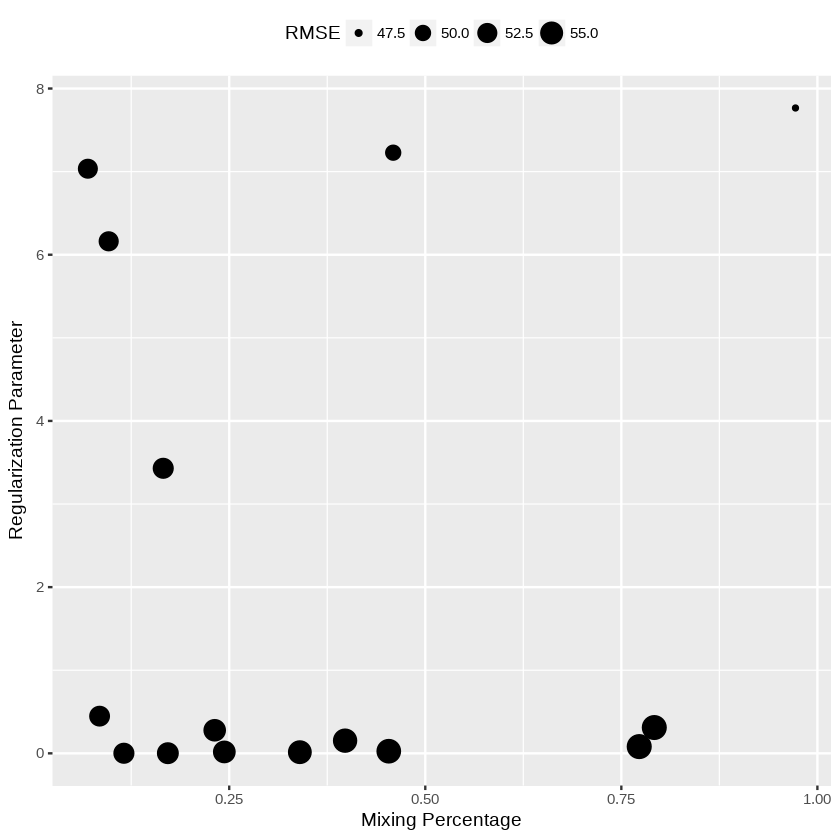

In [23]:
load("data/analysis_results/Monkey-TB-caret-middlelate-regression-15 length random grid-2018-05-10-.RData")
ggplot(models$glmnet) + theme(legend.position = "top")

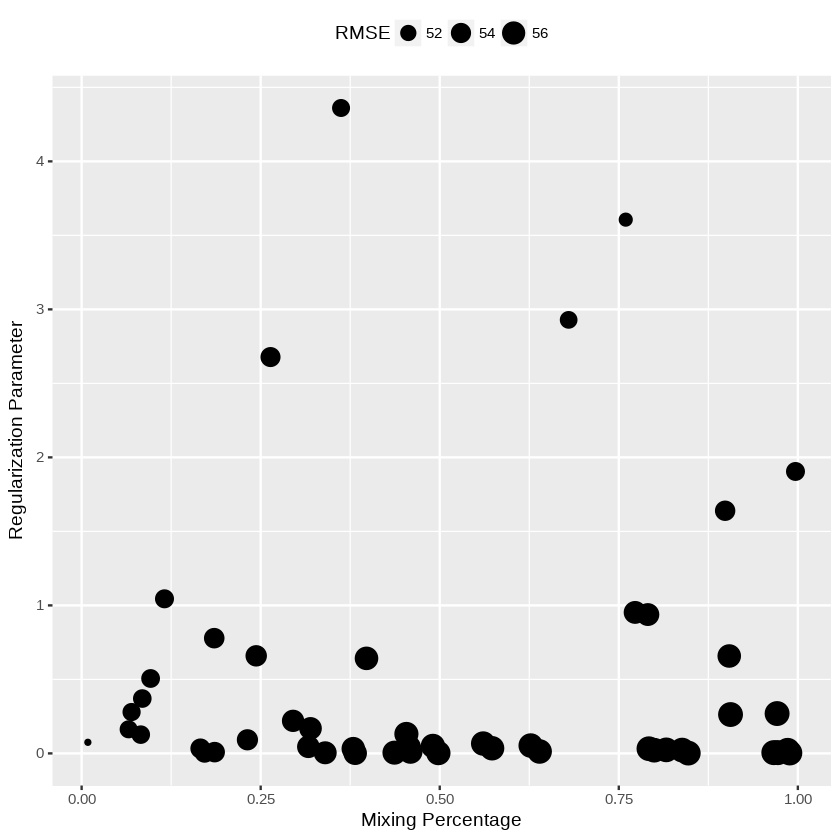

In [21]:
load("data/analysis_results/Monkey-TB-caret-middlelate-regression-50 length random grid_finalpredssaved-2018-05-15-.RData")
ggplot(models$glmnet) + theme(legend.position = "top")

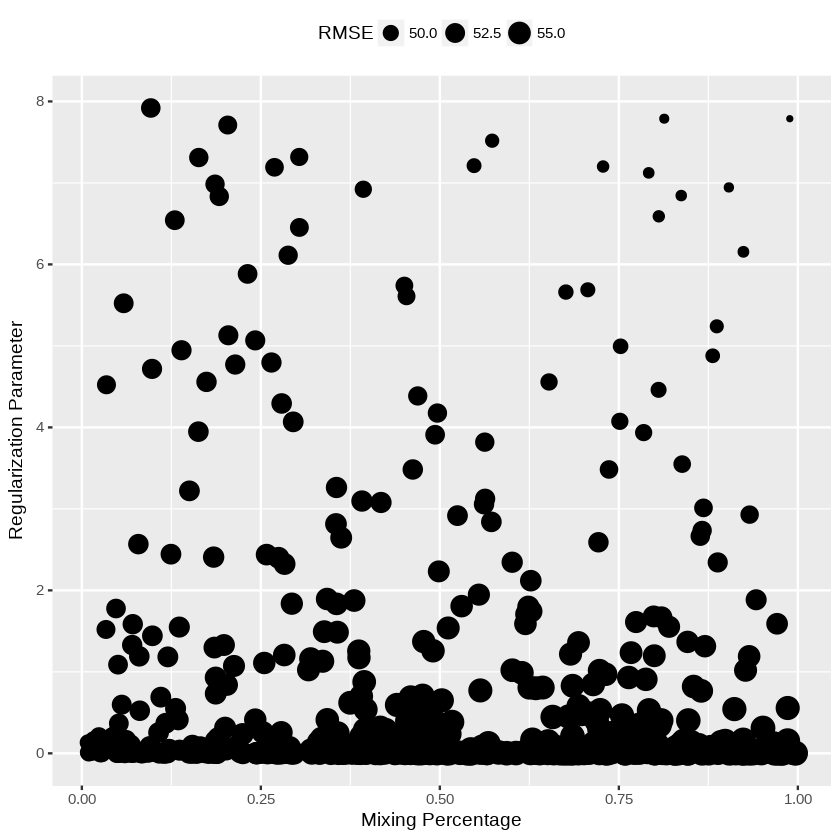

In [22]:
load("data/analysis_results/Monkey-TB-caret-middlelate-regression-500 length random grid-2018-05-14-.RData")
ggplot(models$glmnet) + theme(legend.position = "top")

###### Do a further random search of glmnet parameters in the good neighborhood 0.75 - 1.00 mixing percentage (alpha), 6-20 regularization parameter (lambda)

Code to help me in feature importance with glmnet:
https://amunategui.github.io/binary-outcome-modeling/
More tuning code:
https://www.kaggle.com/petrschonbauer/glmnet-and-randomforest-in-r-caret/code


On round 2, I searched from 1 to a billion for lambda
0.45-1 for alpha
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 0.7997285 and lambda = 9.45612.

RMSE was 47.52 and MAE was ~40.1

On round 3 I searched from 0.5 to 100 for lambda
0.2 to 1 for alpha

Saving the model takes a long time.
I now have good code for doing contour plots to understand the relationships among parameters. THere are a mountain of good values, it is a negatively correlated mountain between alpha and lambda along lambdas around 10.

Round 2 had the best model. I could search along the mountain in finer detail, but I don't think it will get a ton better at this point.

### It seems totally different for classification vs. regression. Using the same grid for classificaiton as I did for round 3 of regression, I got 0.50 accuracy, no better than chance

For classification, 50 samples, round 4 got me to where the mountains are. It's no better than the best performance that I found before.

In [53]:
log10(1)


[1] 0

In [107]:
set.seed = 100
# Sample lambda randomly from 6 to 10 billion, on a log scale
n = 1000
lambda.grid = c(10 ^ runif(n, min = log10(1e0), max = log10(1e2)))
#lambda.grid = 10 ^ runif(n, -3.0, max = log10(1.0)) #c(seq(6,20,by=1), 10 ^ runif(n, min = log10(0.5), max = log10(1e2)))
#alpha.grid = runif(length(lambda.grid), min = 0.0, 0.50)


alpha.grid = runif(length(lambda.grid), min = 0.00, 1.00)

train.grid = data.frame(lambda = sample(lambda.grid, length(lambda.grid)),
                       alpha = sample(alpha.grid, length(lambda.grid)))


In [108]:
print(dim(train.grid))
train.grid

[1] 1000    2


lambda    alpha     
1     9.276383 0.64465386
2     6.754263 0.07299523
3     1.405062 0.76890385
4     5.635903 0.18165546
5     6.398040 0.79103267
6     1.646666 0.12297324
7    62.337969 0.43164990
8    59.398311 0.50187624
9    19.630842 0.99603301
10    4.019417 0.97014303
11   66.885813 0.32165417
12   12.372844 0.71493114
13    2.240992 0.66499935
14   35.130893 0.10982475
15    8.199198 0.82014003
16   88.674121 0.94203521
17   18.685039 0.87161027
18   42.202827 0.11909571
19   63.069861 0.84655230
20    1.599015 0.76499768
21   14.542841 0.99099637
22    1.545221 0.98400193
23   56.465481 0.88173839
24    3.273147 0.85163831
25   79.188164 0.14769738
26   17.195875 0.88868637
27   31.258758 0.34349996
28    3.056471 0.83052977
29   15.999057 0.61629456
30    4.708624 0.16315090
⋮    ⋮         ⋮         
971  89.835864 0.75212005
972   9.651958 0.38443576
973  30.301562 0.64358712
974  49.315563 0.73820930
975  19.746212 0.14373570
976  16.167118 0.95574430
977   7.930304 0.11331201
978   1.123115 0.60191794
979   3.447422 0.40665614
980   9.195294 0.90275724
981  82.993913 0.27404756
982   1.549110 0.83378131
983  11.468409 0.19843491
984  11.323355 0.33910773
985  86.090375 0.09489227
986   1.759404 0.56354516
987   6.427511 0.49722373
988   2.228760 0.95089999
989  36.776141 0.68042396
990   3.019697 0.53951041
991  37.863152 0.66120730
992   8.513115 0.54128501
993  56.830451 0.48208285
994   1.364445 0.07748867
995  58.459134 0.83355422
996  58.874154 0.88925097
997  67.872687 0.34291348
998  20.701678 0.29417583
999  31.742939 0.74632900
1000  3.258298 0.72007900

In [109]:
seed=7

library(doParallel)
# Now we are going to loop over different models
# This code does work as long as I have the appropriate packages downloaded.
start_time <- Sys.time()

cluster = makeCluster(detectCores()-3) # Leaving 3 for other jobs
registerDoParallel(cluster)

methods = c("glmnet")
#methods = c("gbm", "svmRadial", "svmPoly", "ranger", "glmnet", "xgbTree", "dnn")

models = list()


#folds
control <- trainControl(method="cv", index=folds, savePredictions = 'final', allowParallel=TRUE)

for (alg in methods) {
    set.seed(seed)
    print("I have gotten to model:")
    print(alg)
    model = train(time.point~., data=expres.train.point, tuneGrid = train.grid, method=alg, trControl=control) # 
    models[[alg]] = model
}



save.progress(file="Monkey-TB-caret-middlelate-regression-glmnet grid tuning with 1000 samples_looking everywhere_alltimepoints_round2", dir=paste(path, "data/analysis_results", sep="/"))
stopCluster(cluster)
registerDoSEQ()

end_time <- Sys.time()
print(end_time - start_time)

[1] "I have gotten to model:"
[1] "glmnet"


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

Time difference of 11.76419 mins


In [110]:
# models$glmnet$results
models

$glmnet
glmnet 

 210 samples
9050 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 202, 194, 186, 174, 187, 179, ... 
Resampling results across tuning parameters:

  alpha         lambda     RMSE      Rsquared   MAE     
  0.0009629847   1.425906  48.92422  0.2470488  40.72030
  0.0016518221  15.355919  48.99639  0.2460493  40.64566
  0.0028448137   2.579325  49.12565  0.2419667  40.62088
  0.0034924091  88.045596  49.09350  0.2401056  40.62021
  0.0035730314  19.057227  49.24641  0.2377608  40.65131
  0.0041962392  54.636449  49.33769  0.2342456  40.67353
  0.0044033176  24.969521  49.39778  0.2326770  40.69142
  0.0052040615  10.352271  49.56782  0.2267875  40.74994
  0.0066640829  25.085402  49.84366  0.2191323  40.91651
  0.0069636626   6.578579  49.89693  0.2177265  40.95468
  0.0073090750   4.011644  49.95536  0.2162600  40.99795
  0.0073835321  59.335909  49.63504  0.2213443  40.90481
  0.0074278736   3.172765  49.97276  0.2157665  4

Warning message:
“Ignoring unknown aesthetics: shape”Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 50. Consider
specifying shapes manually if you must have them.”Warning message:
“Removed 44 rows containing missing values (geom_point).”geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


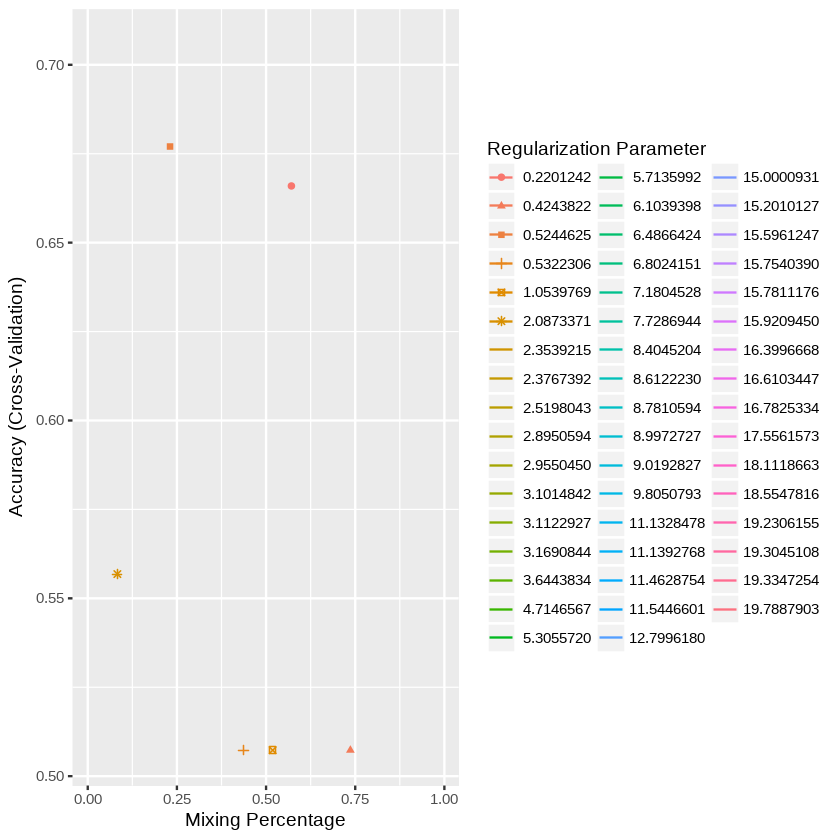

In [30]:
ggplot(models$glmnet)

In [31]:
library(ggplot2)
library(akima)
library(dplyr)


In [68]:
glmres = models$glmnet$results
interpdf <-interp2xyz(interp(x=glmres$alpha, y=glmres$lambda, z=glmres$Accuracy, duplicate="mean"), data.frame=TRUE)

interpdf %>%
  filter(!is.na(z)) %>%
  tbl_df() %>%
  ggplot(aes(x = x, y = y, z = z, fill = z)) + 
  geom_tile() + 
  geom_contour(color = "white", alpha = 0.05) + 
  scale_fill_distiller(palette="Spectral", na.value="white") + 
  theme_bw()

ERROR: Error in interp.old(x, y, z, xo, yo, ncp = 0, extrap = FALSE, duplicate = duplicate, : Lengths of x, y, and z do not match


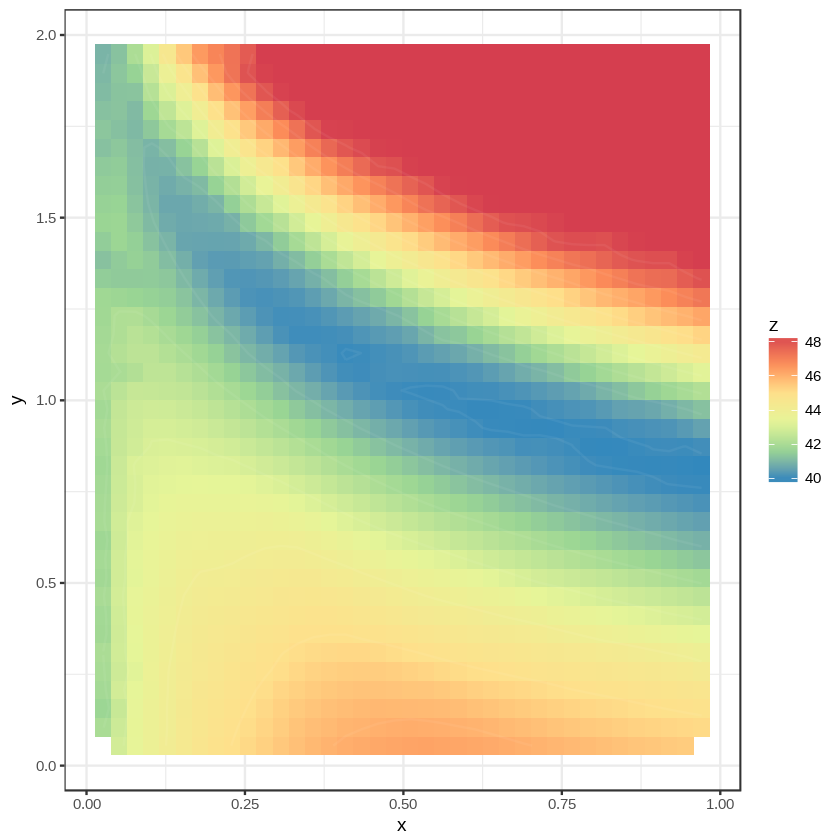

In [111]:
glmres = models$glmnet$results
interpdf <-interp2xyz(interp(x=glmres$alpha, y=log10(glmres$lambda), z=glmres$MAE, duplicate="mean"), data.frame=TRUE)

interpdf %>%
  filter(!is.na(z)) %>%
  tbl_df() %>%
  ggplot(aes(x = x, y = y, z = z, fill = z)) + 
  geom_tile() + 
  geom_contour(color = "white", alpha = 0.05) + 
  scale_fill_distiller(palette="Spectral", na.value="white") + 
  theme_bw()

###### Use a toy dataset to test out the code.

In [13]:
#install.packages("mlbench")
library(mlbench)
data(PimaIndiansDiabetes)

In [14]:
dim(PimaIndiansDiabetes)
levels(PimaIndiansDiabetes$diabetes)
head(PimaIndiansDiabetes)

[1] 768   9

[1] "neg" "pos"

pregnant glucose pressure triceps insulin mass pedigree age diabetes
1 6        148     72       35        0     33.6 0.627    50  pos     
2 1         85     66       29        0     26.6 0.351    31  neg     
3 8        183     64        0        0     23.3 0.672    32  pos     
4 1         89     66       23       94     28.1 0.167    21  neg     
5 0        137     40       35      168     43.1 2.288    33  pos     
6 5        116     74        0        0     25.6 0.201    30  neg

In [15]:
seed=7
library(doParallel)
# Now we are going to loop over different models
# This code does work as long as I have the appropriate packages downloaded.
start_time <- Sys.time()

cluster = makeCluster(detectCores()-3) # Leaving 3 for other jobs
registerDoParallel(cluster)

methods = c("mlpKerasDropout")
#methods = c("gbm", "svmRadial", "svmPoly", "ranger", "glmnet", "dnn")
#LVQ model has bug with a small dataset, so I removed that technique

models = list()


#folds
control <- trainControl(method="cv", search="random", allowParallel=TRUE)

for (alg in methods) {
    set.seed(seed)
    print("I have gotten to model:")
    print(alg)
    model = train(glucose~., data=PimaIndiansDiabetes, method=alg, tuneLength=2, trControl=control)
    models[[alg]] = model
}



save.progress(file="Testing_out_regression_randomgrid_pimaindians_kerasMLP", dir=paste(path, "data/analysis_results", sep="/"))
stopCluster(cluster)
registerDoSEQ()

end_time <- Sys.time()
print(end_time - start_time)

Loading required package: iterators


[1] "I have gotten to model:"
[1] "mlpKerasDropout"


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

Time difference of 1.216593 mins


In [17]:
models

$mlpKerasDropout
Multilayer Perceptron Network with Dropout 

768 samples
  8 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 692, 691, 691, 692, 692, 691, ... 
Resampling results across tuning parameters:

  size  dropout     batch_size  lr         rho        decay         activation
  4     0.17062457  311         0.1658555  0.1717481  0.0731239644  relu      
  9     0.04882408  624         0.9720625  0.4591037  0.0001436764  sigmoid   
  RMSE      Rsquared    MAE     
  44.07184  0.18231839  36.38428
  36.01294  0.02308654  28.28208

RMSE was used to select the optimal model using the smallest value.
The final values used for the model were size = 9, dropout =
 0.04882408, batch_size = 624, lr = 0.9720625, rho = 0.4591037, decay
 = 0.0001436764 and activation = sigmoid.


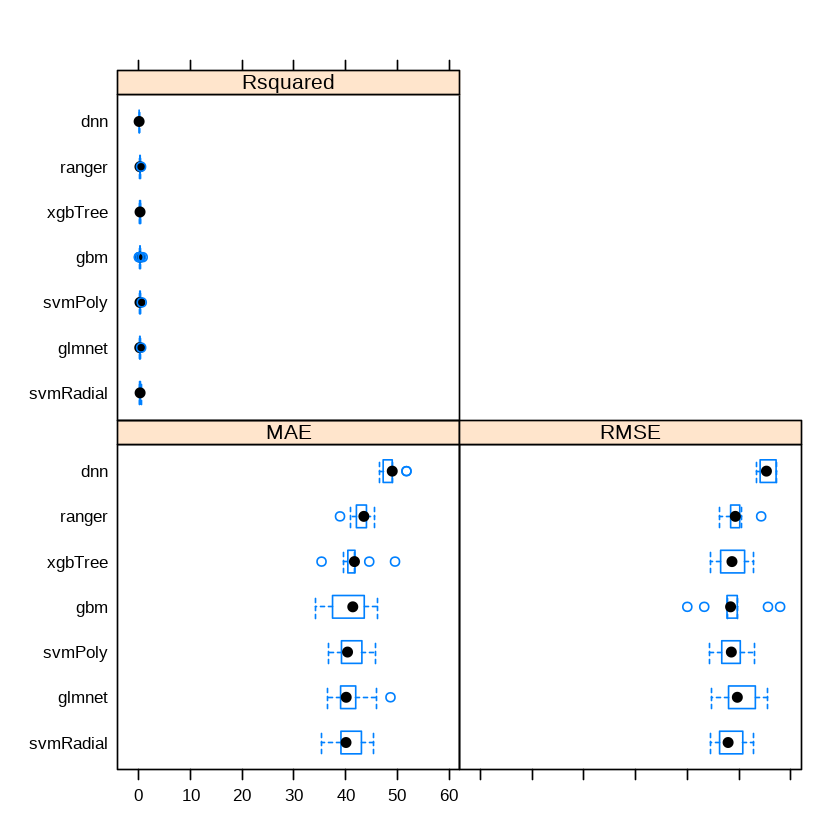

In [18]:
#load()
results = resamples(models)
#summary(results)
bwplot(results)
#dotplot(results)

In [19]:
jpeg(paste(path, "data/analysis_results", paste("Middle_late_Regression_Cross Validation-Parameter Search_tune 50 random_",
          Sys.Date(), "_.jpg", sep=""), sep="/"))
bwplot(results)
dev.off()

png 
  2

In [89]:
print(models)

$xgbTree
eXtreme Gradient Boosting 

768 samples
  8 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 692, 691, 691, 692, 692, 691, ... 
Resampling results across tuning parameters:

  eta        max_depth  gamma      colsample_bytree  min_child_weight
  0.1038771   4         4.5344777  0.6942948         20              
  0.1396548  10         0.8470071  0.4266339         19              
  0.2760031   8         0.9630154  0.3034818          6              
  0.4639144   2         5.6066587  0.5557796         20              
  subsample  nrounds  RMSE      Rsquared   MAE     
  0.7202791  116      26.88279  0.3094913  20.51236
  0.6178563   70      27.05637  0.2984505  20.67504
  0.2992343  398      33.72467  0.1757314  26.18592
  0.9782683  244      28.52698  0.2672164  21.86761

RMSE was used to select the optimal model using the smallest value.
The final values used for the model were nrounds = 116, max_depth = 4, eta
 = 0.1038771, gamma

In [93]:
library(gbm)


ERROR: Error in library(gbm): there is no package called ‘gbm’


### Predicting in Macaques using Genes from Mice

#### Classification
- It works on just the 9051 most variable genes, it might be nice to go wider to all the detected genes, just like I did with the mice, but this is very good.

In [115]:
dim(expres.train.period)

[1]  210 9051

In [ ]:
expres.train.period$time.period

In [114]:
load('data/analysis_results/Bulmer_analysis_log_11June2018-2018-06-11-.RData')

In [116]:
expres.train.period.mice.genes  = expres.train.period[, colnames(expres.train.period) %in% c(mouse.to.monkey$ILLUMINA.HumanHT.12.V4.probe, "time.period")]

In [117]:
dim(expres.train.period.mice.genes)

[1] 210  20

In [118]:
# Maybe just do a quick glmnet just to get an idea!

seed=7

# Now we are going to loop over different models
# This code does work as long as I have the appropriate packages downloaded.
start_time <- Sys.time()

cluster = makeCluster(detectCores()-3) # Leaving 3 for other jobs
registerDoParallel(cluster)

methods = c("glmnet")
#methods = c("gbm", "svmRadial", "svmPoly", "ranger", "glmnet", "dnn")s

models = list()


#folds
control <- trainControl(method="cv", index=folds, search="random", savePredictions = 'final', allowParallel=TRUE)

for (alg in methods) {
    set.seed(seed)
    print("I have gotten to model:")
    print(alg)
    model = train(time.period~., data=expres.train.period.mice.genes, method=alg, tuneLength=100, trControl=control)
    models[[alg]] = model
}

end_time <- Sys.time()
print(end_time - start_time)

save.progress(file="Monkey-TB-caret-middlelate-classification-1000 random grid_glmnetonly_MICEGENES", dir=paste(path, "data/analysis_results", sep="/"))
stopCluster(cluster)
registerDoSEQ()

end_time <- Sys.time()
print(end_time - start_time)

[1] "I have gotten to model:"
[1] "glmnet"
Time difference of 5.029269 mins


Most of the time on this first glmnet attempt was on saving the model. I think it is taking forever because of how much I have saved in memory with the bulmer code. I could probably make this a lot more efficient.

In [121]:
ggplot(models$glmnet)

ERROR: Error in file(con, "rb"): cannot open the connection


plot without title

In [120]:
models

$glmnet
glmnet 

210 samples
 19 predictor
  2 classes: 'late', 'middle' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 202, 194, 186, 174, 187, 179, ... 
Resampling results across tuning parameters:

  alpha        lambda       Accuracy   Kappa     
  0.008410923  0.608800805  0.6715241  0.34181203
  0.008704600  1.198447389  0.6597487  0.31798225
  0.065645739  0.017646240  0.6689128  0.33702424
  0.069748679  0.031940384  0.6724970  0.34406589
  0.078951739  0.766524165  0.6401680  0.27811459
  0.082569093  0.005562061  0.6724970  0.34406589
  0.084700713  0.283062460  0.7012704  0.40175555
  0.094835550  0.205138870  0.6964395  0.39218583
  0.096301542  0.742931762  0.6470005  0.29163666
  0.115697779  0.085985174  0.7000010  0.39895139
  0.134551619  0.030066959  0.6678674  0.33480663
  0.162790778  0.070637395  0.7000010  0.39895139
  0.165855485  0.965960534  0.5165533  0.02107896
  0.171748077  0.467101939  0.6509310  0.29984343
  0.18220541

In [ ]:
write.table(combat_dataset, file = paste(data.dir, "ExpressionData_batcheddataset.txt", sep="/"),sep="\t")
  write.table(expres.com, file = paste(data.dir, "ExpressionData_batchedall.txt", sep="/"),sep="\t")
  Have.Batch.Corrected = T

cut = 0.6

filter = function(x) {IQR(x) / median(x)}
genes.range = apply(expres.com, 1, filter)
criteria = quantile(genes.range, c(1-cut))

genes.f = rownames(expres.com)[genes.range > criteria]
expres.var = expres.com[genes.f,]
write.table(expres.var, file = paste(data.dir, "ExpressionData_batchcorrected_variablegenes.txt", sep="/"),sep="\t")

# Read in pheno.f and expres.var datasets
pheno.f = read.table(file = paste(data.dir, "PhenoData_filtered.txt", sep="/"), sep="\t", header=T)
expres.var = read.table(file = paste(data.dir, "ExpressionData_batchcorrected_variablegenes.txt", sep="/"), header=T, sep="\t")

# Add time period to pheno.f if needed
pheno.f$time.period = as.factor(ifelse(pheno.f$time.point < 3,
                               "pre.infect",
                               ifelse(pheno.f$time.point <= 10,
                                      "early", 
                                      ifelse(pheno.f$time.point >= 90,
                                             "late",
                                             "middle"))))
ML.all.set = data.frame(t(expres.var))

# Filter out the time periods i want
ML.all.set.m.l = ML.all.set[pheno.f$time.period %in% c("middle", "late"),]         # middle late
#ML.all.set.m.l$time.period = droplevels(ML.all.set.m.l$time.period)
pheno.m.l = pheno.f[pheno.f$time.period %in% c("middle", "late"),]

# write the tables
write.table(pheno.m.l, file = paste(data.dir, "Monkey_PhenoData_middle-late.txt", sep="/"),sep="\t")
write.table(ML.all.set.m.l, file = paste(data.dir, "Monkey_Processed_ExpressionData_middle-late.txt", sep="/"),sep="\t")